In [2]:
%matplotlib inline


Тренируем классификатор
=====================

Определим нашу нейронную сеть


Что за датасет?
----------------



Специально для компьютерного зрения pytorch предоставляет модуль
``torchvision``, который может загружать самые распространенные датасеты через модуль
``torchvision.datasets`` и ``torch.utils.data.DataLoader``.

Так же в модуле ``torchvision.transforms`` находятся все необходимые преобразования для предобработки данных

Благодаря этому можно не писать сложный код для обработки а сразу описать архитектуру и начать работать с ней.

Мы будем использовать CIFAR10 
Его классы: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. все изображения в CIFAR-10 размером 3x32x32, т.е. 3-канальные цветные изображения по 32x32 пикселя.





In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

Входные изображения имею диапазон [0, 1].
Мы превратим его в [-1, 1].
Загрузим тренировочный и тестовый датасет при помощи втроенных утилит
Определим семплер для данных



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Приводит диапазон значений входных тензоров от [0,1] к [-1,1] 
#Compose - это метод, который последовательно применяет операции записанные внутри ко входу, т.е. он будет трансформировать изображения
#ToTensor означает, что он превратит входную картинку в тензор.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # выкачивает набор данных CIFAR10 в папку ./data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2) #использует набор данных выше и строит мини-пакеты по 4 картинки в каждом, в 2 потока, перемешивая их

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Выведем картинки из датасета



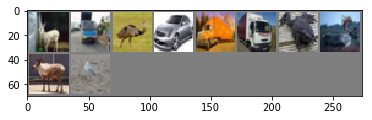

 deer truck  bird   car truck truck  frog  deer  deer  bird


In [5]:
#Функции для отображения картинок
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Взять несколько случайных элементов и вывести на экран
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Показать изображения и метки к ним
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Определим нашу нейронную сеть


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #параметры свертки число входных каналов, число выходных каналов, размер ядра сверт
        self.conv1 = nn.Conv2d(3, 32, 3)
        #Параметры батчнорма - число каналов
        self.batchnorm1 = nn.BatchNorm2d(32)
        #параметры суб дискретизации  - размер ядра, размер смещения
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.batchnorm4 = nn.BatchNorm2d(256)
        #параметры полносвязного размер входного вектора, размер выходного вектора
        self.fc1 = nn.Linear(1024, 120)
        self.batchnorm6 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm7 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = x.view(-1, 1024)
        x = F.relu(self.batchnorm6(self.fc1(x)))
        x = F.relu(self.batchnorm7(self.fc2(x)))
        x = self.activation(self.fc3(x))
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Определим ошибку и оптимизатор



In [7]:
import torch.optim as optim

#Ошибка кросс энтропии без логарифа
criterion = nn.NLLLoss()
#Разновидность оптимизатора градиентного спуска
optimizer = optim.RMSprop(net.parameters(), lr=0.0000001)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

Тренируем сеть в 100 эпох


In [15]:
start_ep = 0
try:
    dicti = torch.load("./checkpoint.ckpt")
    net.load_state_dict(dicti["net"])
    start_ep = dicti["epoch"]
    optimizer.load_state_dict(dicti["optim"])
except:
    print("no save found")
print(start_ep)
net.train()
for epoch in range(start_ep,80):  # Проход в 100 эпох

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #Получить данные
        inputs, labels = data

        #Занулить градиенты
        optimizer.zero_grad()

        # forward + backward + optimize
        #Берем логарифм от выхода для ошибки
        outputs = torch.log(net(inputs))
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        

        running_loss += loss.item()
        if i % 100 == 99:    # вывести на каждом 100 батче
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    #Сохраняем модель, эпоху и параметры оптимизатора
    torch.save({"net":net.state_dict(), "epoch":epoch+1, "optim":optimizer.state_dict()}, "./checkpoint.ckpt")

print('Finished Training')

50
[51,   100] loss: 0.005
[51,   200] loss: 0.004
[51,   300] loss: 0.006
[51,   400] loss: 0.005
[51,   500] loss: 0.006
[51,   600] loss: 0.005
[51,   700] loss: 0.005
[51,   800] loss: 0.005
[51,   900] loss: 0.006
[51,  1000] loss: 0.006
[51,  1100] loss: 0.004
[51,  1200] loss: 0.005
[51,  1300] loss: 0.005
[51,  1400] loss: 0.006
[51,  1500] loss: 0.007
[51,  1600] loss: 0.005
[51,  1700] loss: 0.007
[51,  1800] loss: 0.007
[51,  1900] loss: 0.005
[51,  2000] loss: 0.005
[51,  2100] loss: 0.006
[51,  2200] loss: 0.006
[51,  2300] loss: 0.006
[51,  2400] loss: 0.005
[51,  2500] loss: 0.005
[51,  2600] loss: 0.007
[51,  2700] loss: 0.007
[51,  2800] loss: 0.006
[51,  2900] loss: 0.008
[51,  3000] loss: 0.005
[51,  3100] loss: 0.005
[51,  3200] loss: 0.004
[51,  3300] loss: 0.005
[51,  3400] loss: 0.004
[51,  3500] loss: 0.005
[51,  3600] loss: 0.006
[51,  3700] loss: 0.006
[51,  3800] loss: 0.006
[51,  3900] loss: 0.006
[51,  4000] loss: 0.005
[51,  4100] loss: 0.007
[51,  4200] l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "E:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-b48a1e8d006c>", line 23, in <module>
    outputs = torch.log(net(inputs))
  File "E:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\torch\nn\modules\module.py", line 493, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-6-260e0ea57d34>", line 31, in forward
    x = self.batchnorm3(F.relu(self.conv3(x)))
  File "E:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\torch\nn\modules\module.py", line 493, in __call__
    result = self.forward(*input, **kwargs)
  File "E:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\torch\nn\modules\batchnorm.py", line 83, in forward
    exponential_average_factor, self.eps)
  File "E:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\torch\nn\functional.py", line 1

KeyboardInterrupt: 

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Тестируем сеть, смотрим, как отличаются реальные метки от предсказанных



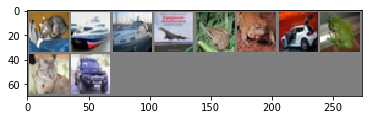

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship  ship plane  deer  frog   car  frog   cat   car


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))
#Сравнить с тем, что выдает сеть
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

In [16]:
#Смотрим какая ошибка по всему тестовому датасету.
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


In [18]:
#Ошибка по каждому классу
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 79 %
Accuracy of  bird : 58 %
Accuracy of   cat : 53 %
Accuracy of  deer : 72 %
Accuracy of   dog : 63 %
Accuracy of  frog : 83 %
Accuracy of horse : 67 %
Accuracy of  ship : 82 %
Accuracy of truck : 82 %
